<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import itertools
random.seed(10)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PROCESSING

In [45]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'
test_dir = '/content/drive/My Drive/Colab Notebooks/charts/Test'

In [46]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
nb_test_samples = 140
epochs = 100
batch_size = 16

In [47]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [ ]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
#import cv2
#import numpy as np
#from PIL import Image
#def myFunc(image):
 #   image = np.array(image)
  #  hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
   # hsv_image = hsv_image.astype('float32')
    #hsv_image = hsv_image / 255.0
    #return Image.fromarray(hsv_image)

In [48]:
# Inspired by random crop functionality from https://jkjung-avt.github.io/keras-image-cropping/
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        #noise_factor = 0.1
        noise = np.random.normal(0.0, scale=sigma, size=batch_x.shape)
        #noise = np.random.normal(0, 0.1, batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [49]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9) #Range starts from 0.6 as I do not expect very dark chart image inputs
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
	test_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical',
	shuffle=False
)

#Adding noise
train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

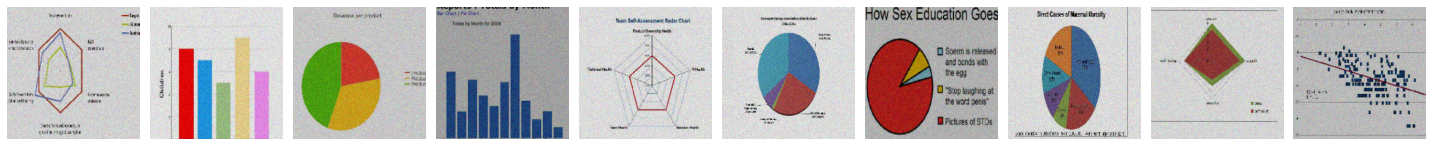

In [ ]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

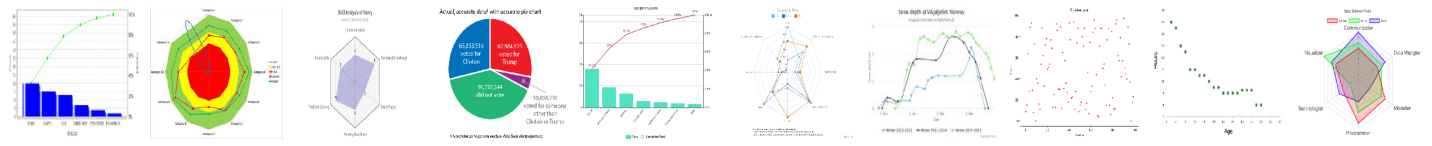

In [ ]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

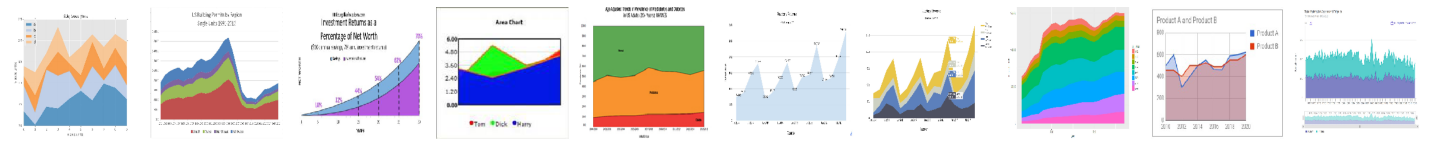

In [ ]:
sample_test_images, _ = next(test_generator)
plotImages(sample_test_images[:10])

#BASELINE CNN MODEL

In [ ]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


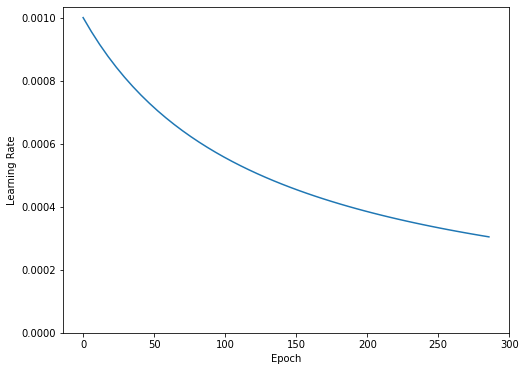

In [ ]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=300, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/300
35/35 [==============================] - 141s 4s/step - loss: 2.5007 - accuracy: 0.2482 - val_loss: 1.7576 - val_accuracy: 0.3828
Epoch 2/300
35/35 [==============================] - 16s 443ms/step - loss: 1.5858 - accuracy: 0.3696 - val_loss: 1.5964 - val_accuracy: 0.4688
Epoch 3/300
35/35 [==============================] - 16s 452ms/step - loss: 1.3156 - accuracy: 0.4714 - val_loss: 1.5710 - val_accuracy: 0.4688
Epoch 4/300
35/35 [==============================] - 15s 439ms/step - loss: 1.1751 - accuracy: 0.5607 - val_loss: 1.5413 - val_accuracy: 0.4922
Epoch 5/300
35/35 [==============================] - 15s 441ms/step - loss: 1.0698 - accuracy: 0.5554 - val_loss: 1.4706 - val_accuracy: 0.4766
Epoch 6/300
35/35 [==============================] - 15s 440ms/step - loss: 0.9668 - accuracy: 0.6304 - val_loss: 1.7150 - val_accuracy: 0.6406
Epoch 7/300
35/35 [==============================] - 15s 442ms/step - loss: 0.8973 - accuracy: 0.6321 - val_loss: 1.7740 - val_accuracy: 0

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/cnn baseline model', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/cnn baseline model/assets


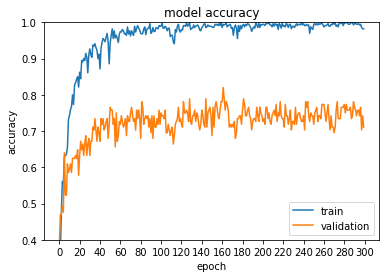

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,320, 20))
plt.ylim(0.4,1.0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

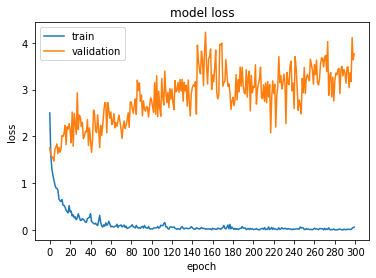

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,320, 20))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
load = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/cnn baseline model')

In [ ]:
y_pred = load.predict(test_generator, batch_size=16 )

In [ ]:
y_prediction = np.argmax(y_pred , axis=1)

In [ ]:
conf_matrix=confusion_matrix(test_generator.classes, y_prediction)

In [ ]:
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']

In [ ]:
#Confusion matrix plotting function taken from https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.55 0.   0.1  0.   0.15 0.1  0.1 ]
 [0.1  0.55 0.1  0.05 0.05 0.1  0.05]
 [0.1  0.   0.55 0.   0.05 0.05 0.25]
 [0.   0.05 0.   0.9  0.   0.05 0.  ]
 [0.   0.05 0.05 0.05 0.65 0.2  0.  ]
 [0.   0.   0.   0.05 0.   0.85 0.1 ]
 [0.1  0.   0.05 0.   0.   0.1  0.75]]


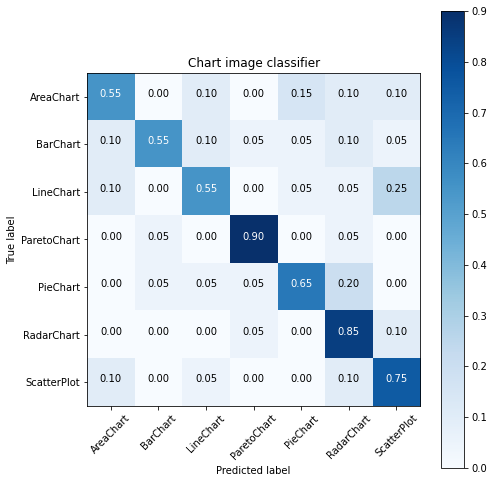

In [ ]:
final_confusion_matrix = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=True, title='Chart image classifier')

In [ ]:
print(classification_report(test_generator.classes, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

   AreaChart       0.65      0.55      0.59        20
    BarChart       0.85      0.55      0.67        20
   LineChart       0.65      0.55      0.59        20
 ParetoChart       0.86      0.90      0.88        20
    PieChart       0.72      0.65      0.68        20
  RadarChart       0.59      0.85      0.69        20
 ScatterPlot       0.60      0.75      0.67        20

    accuracy                           0.69       140
   macro avg       0.70      0.69      0.68       140
weighted avg       0.70      0.69      0.68       140



Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 112 samples in 0.000s...
[t-SNE] Computed neighbors for 112 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 112 / 112
[t-SNE] Mean sigma: 0.706779
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.736713
[t-SNE] KL divergence after 1000 iterations: 0.455675


Text(0.5, 1.0, 't-SNE Visualisation')

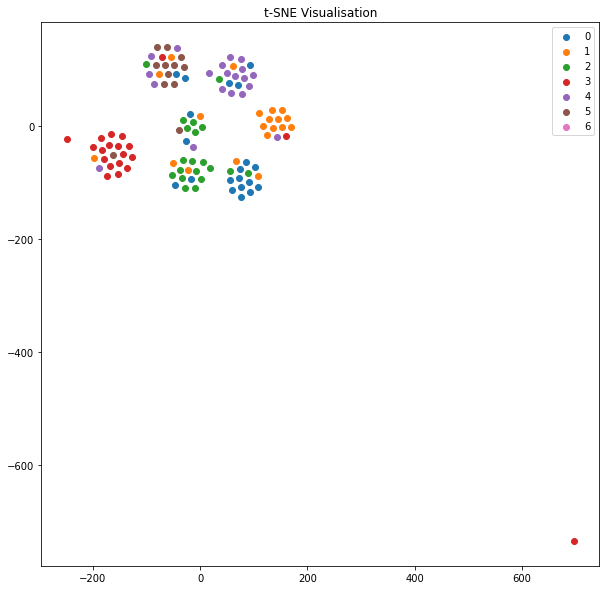

In [90]:
predictions = load.predict(test_generator)

# First, reduce to 7 dimensions with PCA
pca = PCA(n_components=7)
pca_results = pca.fit_transform(predictions)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Next, run t-SNE on the PCA results to obtain a 2D plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=300, verbose = 1)
tsne_results = tsne.fit_transform(pca_results[:112])

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(test_generator.classes[:112], num_classes = 7)
# Create a figure where each class has a unique colour
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(7):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=colour)
plt.legend()
plt.title('t-SNE Visualisation')

#ABLATION STUDY

# <H4>Remove data augementation and gaussian noise - keep learning rate scheduling, keep all classes

In [ ]:
train_datagen_2 = ImageDataGenerator(rescale=1. /255)
val_datagen_2 = ImageDataGenerator(rescale=1. / 255)
test_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

test_generator_2 = test_datagen_2.flow_from_directory( 
	test_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
	shuffle=False)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


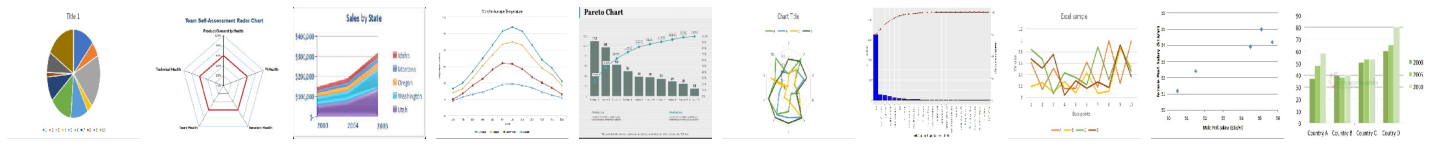

In [ ]:
sample_training_images, _ = next(train_generator_2)
plotImages(sample_training_images[:10])

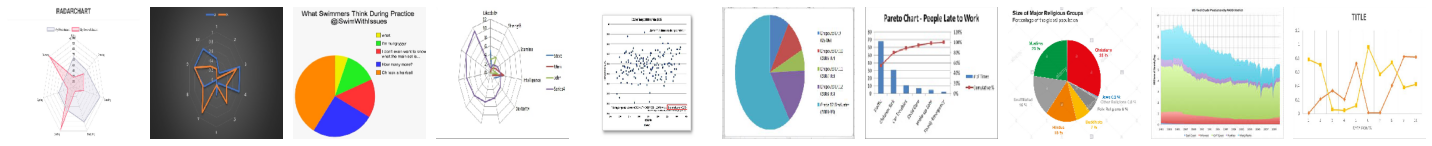

In [ ]:
sample_training_images, _ = next(validation_generator_2)
plotImages(sample_training_images[:10])

In [ ]:
model_repeat = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model_repeat.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 453s 13s/step - loss: 2.2465 - accuracy: 0.3304 - val_loss: 1.3430 - val_accuracy: 0.5078
Epoch 2/100
35/35 [==============================] - 6s 168ms/step - loss: 0.9358 - accuracy: 0.6679 - val_loss: 1.1598 - val_accuracy: 0.5859
Epoch 3/100
35/35 [==============================] - 6s 168ms/step - loss: 0.4868 - accuracy: 0.8411 - val_loss: 1.4794 - val_accuracy: 0.6172
Epoch 4/100
35/35 [==============================] - 6s 166ms/step - loss: 0.2626 - accuracy: 0.9018 - val_loss: 1.2950 - val_accuracy: 0.6875
Epoch 5/100
35/35 [==============================] - 6s 170ms/step - loss: 0.1148 - accuracy: 0.9679 - val_loss: 1.4960 - val_accuracy: 0.6641
Epoch 6/100
35/35 [==============================] - 6s 163ms/step - loss: 0.0875 - accuracy: 0.9696 - val_loss: 1.3190 - val_accuracy: 0.7109
Epoch 7/100
35/35 [==============================] - 6s 168ms/step - loss: 0.0517 - accuracy: 0.9911 - val_loss: 2.0821 - val_accuracy: 0.6641

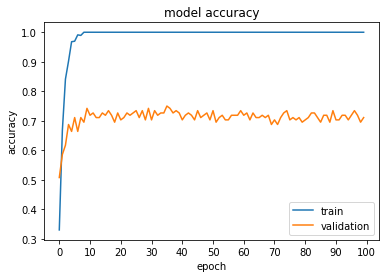

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

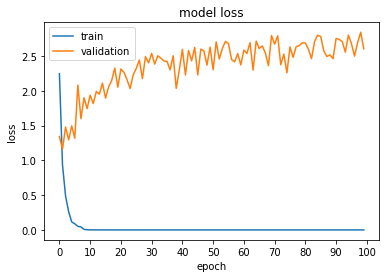

In [ ]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Normalized confusion matrix
[[0.9  0.   0.05 0.   0.05 0.   0.  ]
 [0.15 0.6  0.05 0.1  0.   0.   0.1 ]
 [0.   0.   0.95 0.05 0.   0.   0.  ]
 [0.05 0.05 0.05 0.85 0.   0.   0.  ]
 [0.   0.   0.05 0.1  0.85 0.   0.  ]
 [0.   0.   0.   0.05 0.05 0.9  0.  ]
 [0.   0.1  0.25 0.15 0.   0.05 0.45]]


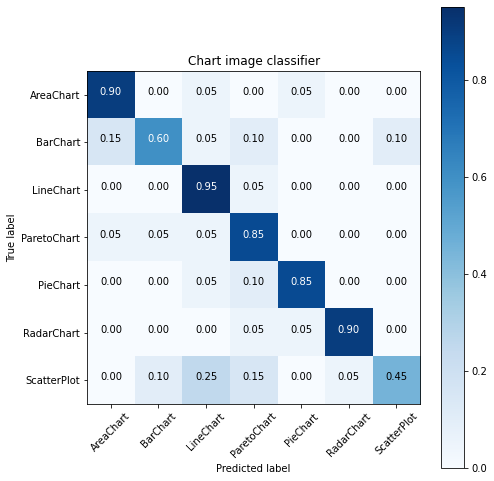

In [ ]:
y_pred_1 = model_repeat.predict(test_generator_2, batch_size=16)
y_prediction_1 = np.argmax(y_pred_1 , axis=1)
conf_matrix_1=confusion_matrix(test_generator_2.classes, y_prediction_1)
final_confusion_matrix_1 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_1, classes=target_names, normalize=True, title='Chart image classifier')

# <H4> Remove gaussian noise and learning rate - keep data augmentation and all classes

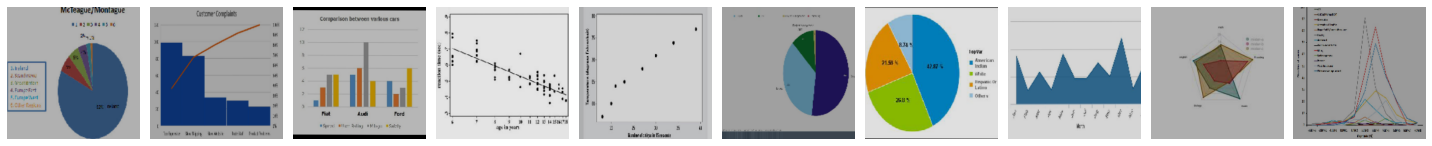

In [ ]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

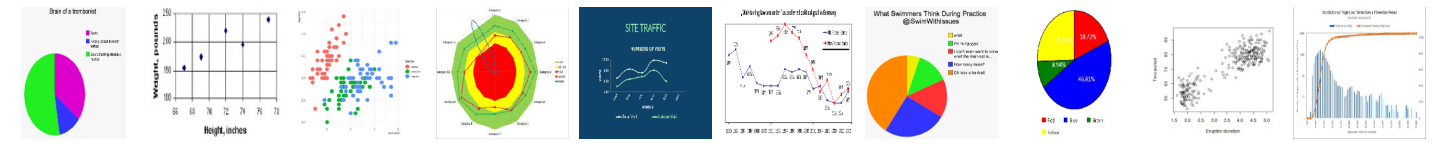

In [ ]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [ ]:
model_repeat_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
lr=0.001
model_repeat_3.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
history3 = model_repeat_3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 11s 316ms/step - loss: 2.6661 - accuracy: 0.2536 - val_loss: 1.5953 - val_accuracy: 0.3047
Epoch 2/100
35/35 [==============================] - 11s 312ms/step - loss: 1.2624 - accuracy: 0.5143 - val_loss: 1.2613 - val_accuracy: 0.5469
Epoch 3/100
35/35 [==============================] - 11s 309ms/step - loss: 0.9389 - accuracy: 0.6411 - val_loss: 1.1413 - val_accuracy: 0.6719
Epoch 4/100
35/35 [==============================] - 11s 306ms/step - loss: 0.7861 - accuracy: 0.6982 - val_loss: 1.1351 - val_accuracy: 0.6016
Epoch 5/100
35/35 [==============================] - 11s 307ms/step - loss: 0.7183 - accuracy: 0.7429 - val_loss: 1.3965 - val_accuracy: 0.6719
Epoch 6/100
35/35 [==============================] - 11s 308ms/step - loss: 0.6232 - accuracy: 0.7821 - val_loss: 1.2095 - val_accuracy: 0.7266
Epoch 7/100
35/35 [==============================] - 11s 305ms/step - loss: 0.4284 - accuracy: 0.8375 - val_loss: 1.4744 - val_accuracy:

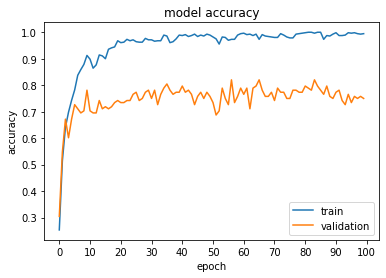

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#<H4>Remove gaussian noise - keep learning rate scheduling, data augmentation and all classes

In [ ]:
model_repeat_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat_4.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [ ]:
history4 = model_repeat_4.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 12s 339ms/step - loss: 2.0276 - accuracy: 0.2804 - val_loss: 1.5815 - val_accuracy: 0.3906
Epoch 2/100
35/35 [==============================] - 12s 335ms/step - loss: 1.2201 - accuracy: 0.5518 - val_loss: 1.5356 - val_accuracy: 0.6328
Epoch 3/100
35/35 [==============================] - 12s 331ms/step - loss: 0.9151 - accuracy: 0.6429 - val_loss: 1.3636 - val_accuracy: 0.5781
Epoch 4/100
35/35 [==============================] - 12s 336ms/step - loss: 0.8199 - accuracy: 0.6768 - val_loss: 1.2462 - val_accuracy: 0.6094
Epoch 5/100
35/35 [==============================] - 12s 337ms/step - loss: 0.7803 - accuracy: 0.6929 - val_loss: 1.2921 - val_accuracy: 0.6484
Epoch 6/100
35/35 [==============================] - 12s 336ms/step - loss: 0.5885 - accuracy: 0.7911 - val_loss: 1.5925 - val_accuracy: 0.7109
Epoch 7/100
35/35 [==============================] - 12s 335ms/step - loss: 0.4656 - accuracy: 0.8286 - val_loss: 1.3832 - val_accuracy:

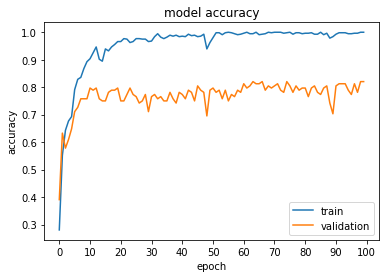

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

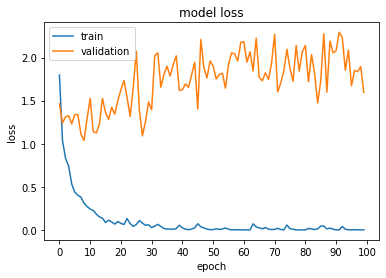

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_4 = model_repeat_4.predict(test_generator, batch_size=16 )

In [ ]:
y_prediction_4 = np.argmax(y_pred_4 , axis=1)

In [ ]:
conf_matrix_4=confusion_matrix(test_generator.classes, y_prediction_4)

In [ ]:
target_names_4 = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']

Normalized confusion matrix
[[0.7  0.05 0.1  0.   0.1  0.   0.05]
 [0.   0.8  0.05 0.15 0.   0.   0.  ]
 [0.   0.   0.65 0.   0.   0.05 0.3 ]
 [0.05 0.05 0.05 0.85 0.   0.   0.  ]
 [0.   0.05 0.05 0.   0.85 0.05 0.  ]
 [0.   0.   0.05 0.   0.05 0.75 0.15]
 [0.   0.   0.1  0.   0.   0.   0.9 ]]


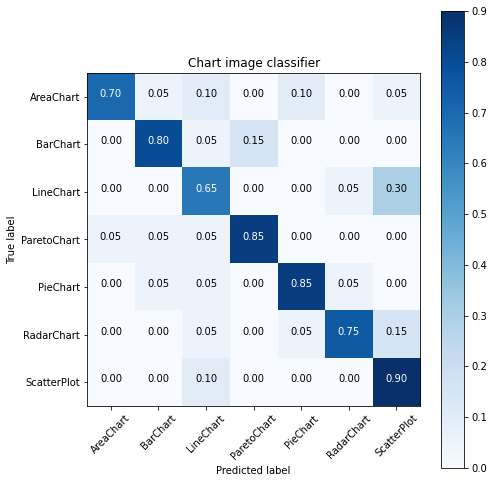

In [ ]:
final_confusion_matrix_4 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_4, classes=target_names_4, normalize=True, title='Chart image classifier')

#<H4>Keep gaussian noise, learning rate scheduling & data aug - remove pareto chart and radar chart classes (only 5 charts)

In [ ]:
train_generator_5 = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical',
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"]) 

validation_generator_5 = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"])

test_generator_5 = test_datagen.flow_from_directory(
	test_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
	shuffle = False,
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"]
)

#Adding noise
train_noisy_5 = noisy_generator(train_generator_5)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
model_repeat_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat_5.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
train_samples = 400
val_samples = 100
test_samples = 100

In [ ]:
history5 = model_repeat_5.fit( 
	train_noisy_5, 
	steps_per_epoch=train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_5, 
	validation_steps= val_samples // batch_size)

Epoch 1/100
25/25 [==============================] - 12s 460ms/step - loss: 1.8751 - accuracy: 0.3550 - val_loss: 1.3014 - val_accuracy: 0.4896
Epoch 2/100
25/25 [==============================] - 11s 459ms/step - loss: 1.1072 - accuracy: 0.5325 - val_loss: 1.1794 - val_accuracy: 0.4896
Epoch 3/100
25/25 [==============================] - 11s 451ms/step - loss: 0.9312 - accuracy: 0.5725 - val_loss: 1.1006 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 11s 450ms/step - loss: 0.6950 - accuracy: 0.6575 - val_loss: 0.9234 - val_accuracy: 0.6042
Epoch 5/100
25/25 [==============================] - 11s 450ms/step - loss: 0.7106 - accuracy: 0.6450 - val_loss: 0.8710 - val_accuracy: 0.6771
Epoch 6/100
25/25 [==============================] - 11s 456ms/step - loss: 0.6111 - accuracy: 0.7250 - val_loss: 0.9579 - val_accuracy: 0.6354
Epoch 7/100
25/25 [==============================] - 11s 454ms/step - loss: 0.6087 - accuracy: 0.7200 - val_loss: 0.8350 - val_accuracy:

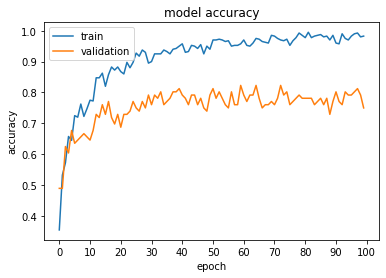

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_5 = model_repeat_5.predict(test_generator_5, batch_size=16 )

In [ ]:
y_prediction_5 = np.argmax(y_pred_5 , axis=1)

In [ ]:
conf_matrix_5=confusion_matrix(test_generator_5.classes, y_prediction_5)

In [ ]:
target_names_5 = ['AreaChart', 'BarChart', 'LineChart', 'PieChart', 'ScatterPlot']

Normalized confusion matrix
[[0.75 0.05 0.1  0.05 0.05]
 [0.05 0.75 0.1  0.05 0.05]
 [0.05 0.05 0.85 0.   0.05]
 [0.   0.05 0.05 0.9  0.  ]
 [0.05 0.05 0.25 0.   0.65]]


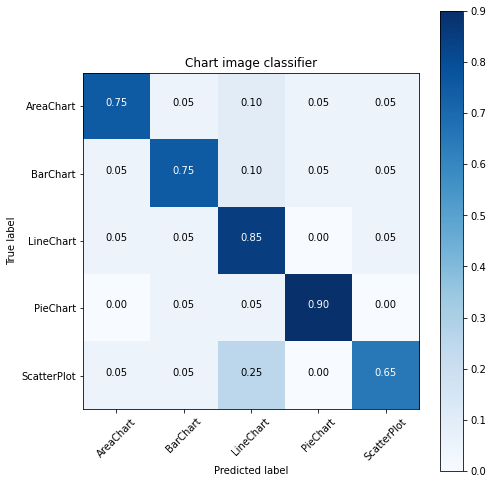

In [ ]:
final_confusion_matrix_5 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_5, classes=target_names_5, normalize=True, title='Chart image classifier')